In [1]:
import pandas
import pandas as pd
import numpy as np
import os
import sqlalchemy
import pymysql
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

%matplotlib inline
import matplotlib.pyplot as plt

The data from the df below is the basis list of the stocks that I will be using the for built of the traded bot.

In [3]:
df = pd.read_csv("data/SP500Data.csv")

Creation of engine to use mysql in pycharm

In [2]:
url_object = sqlalchemy.URL.create(
    "mysql+pymysql",
    username="root",
    password="luis",  # plain (unescaped) text
    host="localhost",
    database="data",
    )
eng = sqlalchemy.create_engine(url_object)

Below is a method to get buy and sell signals.

In [3]:
def reducedOnes(numpyArray):
    for i in range(0, len(numpyArray)):
            if numpyArray[i] == 1:
                j = i + 1
                while j < len(numpyArray) and numpyArray[j] != 0:
                    numpyArray[j] = 0
                    j += 1
    return numpyArray

In [67]:
df = pd.DataFrame
directory = os.fsencode("data/SP500Data")
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    df = pd.read_csv("data/SP500Data/%s"%filename)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", drop=True, inplace=True) #make sure to convert date to datetime so it can be recognized as such by pandas
    df = df.replace("[^.0-9]", "", regex=True).astype(float) #Here we use some regex to convert all columns to float values
    #Percentage return from previous close day
    df['Returns'] = df['Close'].pct_change().round(8)
    df = df[df.Returns != 0] #Drop value from day when there was no trade.
    # Calculate weekly returns
    df['Weekly Return'] = ((df['Close'] - df['Close'].shift(7)) / 100).round(8)
    # Calculate monthly returns
    df['Monthly Return'] = ((df['Close'] - df['Close'].shift(30)) / 100).round(8)
    # Calculate the daily price changes
    df['Change'] = df['Close'].diff().round(6)
    # Separate the gains and losses
    df['Gain'] = np.where(df['Change'] > 0, df['Change'], 0).round(6) #if 'Change' > 0 then it is a gain
    df['Loss'] = np.where(df['Change'] < 0, -df['Change'], 0).round(6) #else it is a loss.
    # Calculate the average gains and losses
    df['Avg Gain'] = df['Gain'].rolling(window=14).mean().round(6)
    df['Avg Loss'] = df['Loss'].rolling(window=14).mean().round(6)
    # Calculate the Relative Strength (RS)
    df['RS'] = (df['Avg Gain'] / df['Avg Loss']).round(6)
    # Calculate the RSI
    df['RSI'] = (100 - (100 / (1 + df['RS']))).round(6)
    # Calculate the Simple Moving Average with a span of 5 days
    df['MA5'] = df['Close'].rolling(window=5).mean().round(6)
    # Calculate the Simple Moving Average with a span of 10 days
    df['MA10'] = df['Close'].rolling(window=10).mean().round(6)
    # Calculate the Simple Moving Average with a span of 20 days
    df['MA20'] = df['Close'].rolling(window=20).mean().round(6)
    # Calculate the Simple Moving Average with a span of 50 days
    df['MA50'] = df['Close'].rolling(window=50).mean().round(6)
    # Calculate the Simple Moving Average with a span of 200 days
    df['MA200'] = df['Close'].rolling(window=200).mean().round(6)
    # Calculate the EWMA with a span of 10 days
    df['EWMA10'] = df['Close'].ewm(span=10, adjust=False).mean().round(6)
    # Calculate the EWMA with a span of 12 days for MACD
    df['EWMA12'] = df['Close'].ewm(span=12, adjust=False).mean().round(6)
    # Calculate the EWMA with a span of 26 days for MACD
    df['EWMA26'] = df['Close'].ewm(span=26, adjust=False).mean().round(6)
    # Calculate the EWMA with a span of 50 days
    df['EWMA50'] = df['Close'].ewm(span=50, adjust=False).mean().round(6)
    # Calculate the EWMA with a span of 200 days
    df['EWMA200'] = df['Close'].ewm(span=200, adjust=False).mean().round(6)
    # Calculate the 20-day rolling volatility (standard deviation of returns)
    df['Volatility20'] = df['Returns'].rolling(window=20).std().round(6)
    # Calculate the 30-day rolling volatility
    df['Volatility30'] = df['Returns'].rolling(window=30).std().round(6)
    # Calculate the MACD line
    df['MACD'] = (df['EWMA12'] - df['EWMA26']).round(6)
    # Calculate the Signal line (9 periods EMA of the MACD line)
    df['Signal Line'] = (df['MACD'].ewm(span=9, adjust=False).mean()).round(6)
    # Calculate the MACD Histogram
    df['MACD Histogram'] = (df['MACD'] - df['Signal Line']).round(6)
    #Calculate Standard Dev for 20MA
    df["STD20"] = (df['Close'].rolling(window=20).std()).round(6)
    # Calculate the Upper and Lower Bollinger Bands
    df['Upper Band'] = (df['MA20'] + (2 * df['STD20'])).round(6)
    df['Lower Band'] = (df['MA20'] - (2 * df['STD20'])).round(6)
    # Calculate the typical price
    df['Typical Price'] = ((df['High'] + df['Low'] + df['Close']) / 3).round(6)
    # Calculate the cumulative typical price * volume
    df['Cumulative TPV'] = ((df['Typical Price'] * df['Volume']).cumsum()).round(6)
    # Calculate the cumulative volume
    df['Cumulative Volume'] = (df['Volume'].cumsum()).round(6)
    # Calculate the VWAP
    df['VWAP'] = (df['Cumulative TPV'] / df['Cumulative Volume']).round(6)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(how='any', inplace=True)
    #price rises next day then buy, if not then 0 and we sell
    df['Buy'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    filename = (filename[:-4]).lower()
    df.to_sql(name="%s"%filename, con=eng, if_exists="replace", index=True)
    #df.to_csv(path_or_buf="data/SP500Data/%s"%filename) Commented it out because I am doing sql now.

C:\Users\emili\AppData\Local\Temp\ipykernel_15040\2757031597.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().round(8)
C:\Users\emili\AppData\Local\Temp\ipykernel_15040\2757031597.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().round(8)
C:\Users\emili\AppData\Local\Temp\ipykernel_15040\2757031597.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill

Model using MA5, MA20, RSI to get label BuyOrSell.

In [76]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [85]:
z = 0
dfOne = pd.read_sql('SELECT MA5, MA20, RSI, MACD, `Signal Line`, Buy FROM `a`', con=eng)
df = pd.DataFrame
directory = os.fsencode('data/SP500Data')
for file in os.listdir(directory):
    z+=1
    if z == 1:
        continue
    if z > 10:
        break
    filename = os.fsdecode(file)
    filename = (filename[:-4]).lower()
    df = pd.read_sql('SELECT MA5, MA20, RSI, MACD, `Signal Line`,Buy FROM `%s`'%filename, con=eng)
    dfOne = pd.concat([df, dfOne], axis=0)
features = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal Line']
X_train = dfOne[features]
target = ['Buy']
y_train = dfOne[target]
model.fit(X_train, y_train.values.ravel())


RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [86]:
dfOne.describe()

,MA5,MA20,RSI,MACD,Signal Line,Buy
count,67343.000000,67343.000000,67343.000000,67343.000000,67343.000000,67343.000000
mean,55.921373,55.728812,52.844498,0.182612,0.183633,0.516951
std,83.481563,83.198255,15.990577,2.093908,1.960649,0.499716
min,0.070000,0.080000,0.000000,-32.617617,-29.219735,0.000000
25%,9.634000,9.565500,41.449043,-0.138130,-0.125889,0.000000
50%,28.286000,28.309500,52.954903,0.048166,0.048041,1.000000
75%,63.272000,63.106750,64.406896,0.460987,0.443835,1.000000
max,674.920000,666.777500,99.894779,30.810259,27.076123,1.000000


In [87]:
z = 0
df = pd.DataFrame
directory = os.fsencode('data/SP500Data')
for file in os.listdir(directory):
    z += 1
    if z <= 485:
        continue
    filename = os.fsdecode(file)
    filename = (filename[:-4]).lower()
    df = pd.read_sql('SELECT MA5, MA20, RSI, MACD, `Signal Line`,Buy FROM `%s`'%filename, con=eng)
    features = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal Line']
    X_test = df[features]
    target = ['Buy']
    y_test = df[target]
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred[y_pred >= 0.6] = 1
    y_pred[y_pred < 0.6] = 0
    prec = precision_score(y_test, y_pred)
    print(prec, filename)


0.5133037694013304 wynn
0.5219966159052454 xel
0.4936708860759494 xom
0.5088105726872246 xyl
0.5495283018867925 yum
0.5084033613445378 zbh
0.5608342989571263 zbra
0.5089514066496164 zts


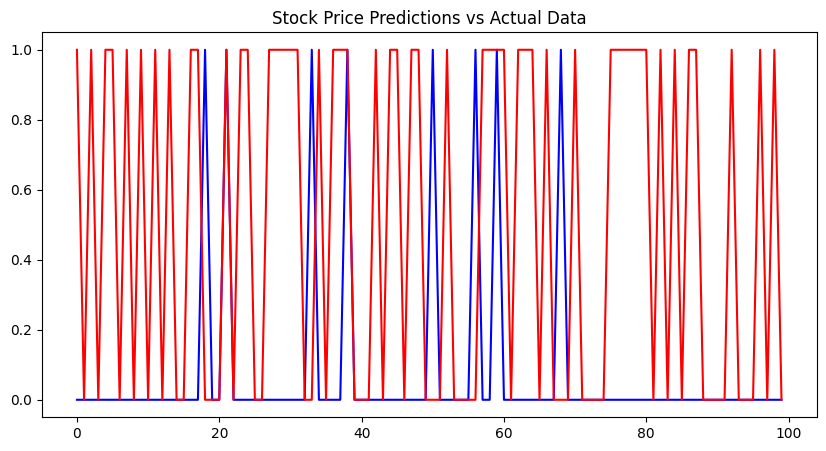

In [83]:
df = pd.read_sql('SELECT MA5, MA20, RSI, Buy FROM `a`')
plt.figure(figsize=(10,5))
plt.plot(range(len(y_pred[-100:])), y_pred[-100:], label='predictions', color='blue')
plt.plot(range(len(y_test[-100:])), y_test[-100:], label='actual', color='red')
plt.title('Stock Price Predictions vs Actual Data')
plt.show()

Model RandomForestRegressor using MA5, MA20, RSI to get closing price. Not Good because it forgets each time it fits.

In [75]:
modelTwo = RandomForestRegressor(n_estimators=100, random_state=1)